# Assignment

We build on the feature engineering we did in the last assignment and run k-means on the data with RFM features in order to do **customer segmentation**. Since k-means is unsupervised, we will also encounter challenges around interpreting results at the end. 

In [1]:
import pandas as pd
col_names = ['user_id', 'gender', 'address', 'store_id', 'trans_id', 'timestamp', 'item_id', 'quantity', 'dollar']
churn = pd.read_csv("retail-churn.csv", sep = ",", skiprows = 1, names = col_names)
churn.head()

,user_id,gender,address,store_id,trans_id,timestamp,item_id,quantity,dollar
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


Run the feature engineering steps on the data to extract RFM features.  

In [2]:
churn['date'] =  pd.to_datetime(pd.to_datetime(churn['timestamp'], format = '%m/%d/%Y %H:%M').dt.date)
churn_agg = churn.groupby(['user_id', 'date']).agg({'dollar': 'sum', 'quantity': 'sum'})
churn_agg = churn_agg.reset_index()
churn_roll = pd.DataFrame()
churn_roll['dollar_roll_sum_7D'] = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['dollar'].sum()
churn_roll['quantity_roll_sum_7D'] = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['quantity'].sum()
churn_roll = churn_roll.reset_index()
churn_roll['last_visit_ndays'] = churn_agg.groupby('user_id')['date'].diff(periods = 1).dt.days
print(churn_roll.shape)

# Should we impute or drop NaN/NaT in churn_roll['last_visit_ndays']?
imputation_value = churn_roll['last_visit_ndays'].max() # None # 
if imputation_value is None:
    # Drop (Remove all rows with NaN):
    churn_roll.dropna(inplace = True)
    print(churn_roll.shape)
else:
    # Impute (Replace all NaN in last_visit_ndays):
    churn_roll['last_visit_ndays'] = churn_roll['last_visit_ndays'].fillna(imputation_value)

churn_roll.head()

(37058, 5)


,user_id,date,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,1113,2000-11-12,420.0,5.0,118.0
1,1113,2000-11-26,558.0,3.0,14.0
2,1113,2000-11-27,1182.0,9.0,1.0
3,1113,2001-01-06,628.0,9.0,40.0
4,1250,2001-02-04,734.0,5.0,118.0


The RFM features are:  'dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays'

1. Train a k-means algorithm on the 3 normalized RFM features using $k = 10$. What are the cluster centroids? The cluster centroids should be reported in the **original scale**, not the normalized scale. <span style="color:red" float:right>[2 point]</span> 

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Extract the RFM features
rfm_features = churn_roll[['dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays']]

# Instantiate a scaler
scaler = StandardScaler()

# Normalize the RFM features
normalized_rfm_features = scaler.fit_transform(rfm_features)

# Train the K-means algo with 10 clusters
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(normalized_rfm_features)

# Scale back the cluster centroids to the original scale
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Create a DataFrame of the cluster centroids
centroids_df = pd.DataFrame(centroids, columns=rfm_features.columns)

# Print the DataFrame
centroids_df

,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,594.162998,7.084917,114.990500
1,3405.418803,33.667832,10.397047
2,457.827969,5.993721,16.225431
3,7679.676420,59.106713,22.523236
4,19804.400000,972.800000,3.600000
5,60972.600000,151.800000,13.200000
6,21942.462687,84.880597,12.507463
7,1521.269177,17.206208,10.543570
8,2584.957701,25.097471,114.357701
9,34162.941176,296.058824,1.352941


**Reason: To train a k-means algorithm on the 3 normalized RFM features using 𝑘=10 and determine the cluseter centroids.**

**Conclusion:
The code extracts the RFM features from the churn_roll DataFrame.** 

**Instantiates a StandardScaler object to normalize the data so that all of the features have a similar range.**

**Normalizes the RFM features using the StandardScaler object by fit_transform() method on the StandardScaler object. The fit_transform() method learns the distribution of the data and then transforms the data so that it has a mean of 0 and a standard deviation of 1.**

**Creates a KMeans object with n_clusters=10.**

**Trains the KMeans model on the normalized RFM features using the fit() method.**

**Clusters the centroids using the cluster_centers_ attribute of the KMeans object.**

**Scales back the cluster centroids to the original scale using the inverse_transform() method of the StandardScaler object so that the values are in the same units as the original data.**

**The outcome can be used to cluster customers based on their RFM features.**

2. Our earlier choice of $k=10$ was arbitrary. To find a better number of $k$ create a **scree plot**, which plots the number of clusters $k$ on the x-axis and the sum of squared distances from each point to its cluster centroid on the y-axis. We can get the latter by calling the `inertia_` attribute as shown in the lab. Plot the scree plot for $k$ values from 1 to 15. <span style="color:red" float:right>[4 point]</span>

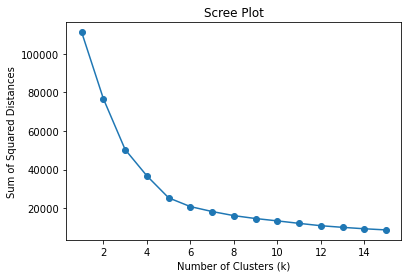

In [6]:
import matplotlib.pyplot as plt

# Create a list with a range of K values and an empty inertia list
k_values = range(1, 16)
inertia = []

# Loop through each K value and get the inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_rfm_features)
    inertia.append(kmeans.inertia_)
    
# Plot the scree plot
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Scree Plot')
plt.show()

**Reason: To find a better number of 𝑘 by creating a scree plot which plots the number of clusters 𝑘 on the x-axis and the sum of squared distances from each point to its cluster centroid on the y-axis. We can get the latter by calling the inertia_ attribute as shown in the lab. Plot the scree plot for 𝑘 values from 1 to 15. Conclusion is question 3.**

3. Based on the scree plot, what is a good value to pick for $k$? Provide a brief justification for your choice. <span style="color:red" float:right>[2 point]</span>

**Conclusion: Based on the scree plot, a good value to pick for k is 5. This is because the sum of squared distances decreases rapidly after 5 clusters, and then levels off. This indicates that after 5 clusters, the data points are not being clustered any more effectively.**

4. Train a k-means algorithm on the RFM features using your new value of $k$. Report:
- the size (number of items) of each cluster
- the mean of each cluster in the original scale
- the standard deviation of each cluster in the Z-normalized scale
<span style="color:red" float:right>[2 point]</span>

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Create a KMeans object with k=5
kmeans = KMeans(n_clusters=5, random_state=42)

# Normalize the RFM features
normalized_rfm_features = StandardScaler().fit_transform(churn_roll[['dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays']])

# Fit the KMeans model to the normalized RFM features
kmeans.fit(normalized_rfm_features)

# Assign the cluster labels back to our data
churn_roll['cluster_label'] = kmeans.labels_

# Get the size (number of items) of each cluster
cluster_sizes = churn_roll['cluster_label'].value_counts().sort_index()

# Get the mean of each cluster in the original scale
cluster_means = churn_roll.groupby('cluster_label')[['dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays']].mean()

# Get the standard deviation of each cluster in the Z-normalized scale
cluster_std = churn_roll.groupby('cluster_label')[['dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays']].std()

print('Cluster sizes:')
print(cluster_sizes)
print()
print('Cluster means (original scale):')
print(cluster_means)
print()
print('Cluster standard deviation (Z-normalized scale):')
print(cluster_std)

Cluster sizes:
0    23194
1    10639
2     3158
3       57
4       10
Name: cluster_label, dtype: int64

Cluster means (original scale):
               dollar_roll_sum_7D  quantity_roll_sum_7D  last_visit_ndays
cluster_label                                                            
0                      837.404631             10.015090         14.174787
1                      927.477113             10.117586        114.877056
2                     4500.952502             39.753325         18.685560
3                    35457.385965            165.982456         10.543860
4                    19804.400000            972.800000          3.600000

Cluster standard deviation (Z-normalized scale):
               dollar_roll_sum_7D  quantity_roll_sum_7D  last_visit_ndays
cluster_label                                                            
0                      672.826728              7.172033         13.945396
1                      891.356540              8.639649         11.038113

**Reason: To train a k-means algorithm on the RFM features using your new value of 𝑘 and Report:**
**the size (number of items) of each cluster,**
**the mean of each cluster in the original scale, and**
**the standard deviation of each cluster in the Z-normalized scale.** 

**Conclusion: Trained a k-means algorithm on the RFM features using new value of k (5) and subsequently reported the size of each cluster (0 is 23194, 1 is 10639, 2 is 3158, 3 is 57, and 4 is 10), mean of each cluster in the original scale (see above), and the standard deviation of each cluster in the Z-normalized scale (see above).**

5. Pick 3 clusters at random and describe what makes them different from one another (in terms of their RFM features). <span style="color:red" float:right>[3 point]</span>

**The first cluster is made up of customers who are recent, frequent, and high-value. They are the most valuable customers.**

**The second cluster is made up of customers who are recent and frequent but they are not high-value. They are likely to be new customers who are still in the process of being converted into high-value customers.**

**The third cluster is made up of customers who are not recent but are frequent and high-value.**

# End of assignment